# COGS 108 - EDA Checkpoint

# Names

- Maxwell Fang
- Long Le
- Huy Trinh
- Hasan Shaikh
- Mohammed Master

<a id='research_question'></a>
# Research Question

How does the spice level of instant ramen affect the star rating on the www.theramenrater.com in regards to preference across each country?

# Dataset(s)


- Dataset Name: Top Ramen Ratings 2022
- Link to the dataset: https://www.kaggle.com/datasets/ankanhore545/top-ramen-ratings-2022
- Number of observations: 4120

The Top Ramen Ratings 2022 dataset is found on Kaggle. The dataset contains brand name, variety or ramen package name, style, country and stars. 

The dataset is the ratings for the ramen reviewed by the The Ramen Rater blog. The data includes the brand of the ramen, the name of the ramen, the packaging style, country of origin, and the star rating.

# Setup

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from category_dict import spiciness_dict
import re

# map libraries
## YOUR CODE HERE
import geopandas as gpd
import folium
from folium.plugins import StripePattern

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

Below is the `DataFrame` for the csv file we obtained from Kaggle.

In [2]:
## YOUR CODE HERE
ramen = pd.read_csv('ramen_rating.csv')
ramen.head()

,Review #,Brand,Variety,Style,Country,Stars,T
0,4120,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,NaN
1,4119,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,NaN
2,4118,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,NaN
3,4117,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,NaN
4,4116,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,NaN


# Data Cleaning

First, we want to only keep the columns that are necessary for our analysis. Columns such as `Review #` and `T` are not needed for this analysis. Because of that reason, we are removing those columns from our analysis.

In [3]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df = ramen.drop(columns=['T','Review #'])
df.head()

,Brand,Variety,Style,Country,Stars
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75


## Feature Engineering
We want to add the spiciness column from extracting the text from `Variety` column. First, we want to see if `mild`, `medium`, `spicy`, or `hot` is in the text itself. If any of those words is in the text, we would use the according spiciness scale to categorize the group.

In [4]:
spicy_levels = ['mild','medium','spicy','hot']
def spiciness(text):
    text= text.lower()
    for spice in spicy_levels:
        if spice in text:
            return spice
    return 'pepper free'

df['spiciness'] = df['Variety'].apply(spiciness)
df.head()

,Brand,Variety,Style,Country,Stars,spiciness
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,pepper free
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,pepper free
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,pepper free
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,pepper free
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,pepper free


In [5]:
df.spiciness.value_counts()

pepper free    3525
spicy           446
hot             128
mild             21
Name: spiciness, dtype: int64

With this simple text extraction, we are able to categorize almost 600 of these instant ramens. Next, we want to use the popular phrases in the variety text to manually categorize those phrases. Every phrase is made up from splitting up the string in the column `Variety` to pairs of words. Then, we loop through instant noodle name to count the occurence of these phrases.

In [6]:
# extracting spiciness from text
# cleaning the string from the Variety column
variety_list = (df['Variety'].str.lower()
                .str.replace('[^a-zA-Z]', ' ', regex=True)
                .str.replace(' +', ' ', regex=True).values)

# finding the most popular phrases to catagorize
pairs_dict = {}
for i in variety_list:
    words = i.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in pairs_dict:
            pairs_dict[pair] += 1
        else:
            pairs_dict[pair] = 1
            
# only take the popular phrase if it appears more than 10 times
popular_phrases = [(i, pairs_dict[i]) for i in pairs_dict if pairs_dict[i] > 10]
popular_phrases.sort(key=lambda x: x[1],reverse = True)
popular_phrases[:6] 

[('instant noodles', 298),
 ('noodle soup', 178),
 ('cup noodles', 161),
 ('instant noodle', 134),
 ('tom yum', 117),
 ('chicken flavor', 104)]

From these most used phrases, phrases such as `'instant noodles'` or `'noodle soup'` or `'cup noodles'` are not informative. Because of that reason, we cannot use these uninformative phrases to categorize the spiciness. On the other hand, we can use phrases like `'tom yum'` and `'chicken flavor'` to categorize their spiciness level. For example, `soy sauce` would be `mild`, and `tom yum` would be `hot`. We include our categorization in the `category_dict.py` file in the same directory as this Jupyter Notebook.

Then, we loop through the every row to find if the `Variety` column contains any of the pairs that we previously categorized. If the phrase exists in its packaging name, we categorize it with its appropriate spiciness according to the `category_dict.py`. 

In the end, we decided to merge `mild` and `medium` together since the Scoville units were relatively close to each other. Similarly, we decided to merge `hot` and `fiery` since the value counts for `fiery` were extremely low. 

In [7]:
spicy_levels = ['mild','spicy','hot']
def spiciness(text):
    # catch if the spciniess is directly in the text
    text = re.sub('r[^a-zA-Z]', ' ', text.lower())
    text = re.sub(' +', ' ', text)
    for spice in spicy_levels:
        if spice in text:
            return spice
    
    # catch if the spiciness is implied in the text 
    words = text.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in spiciness_dict:
            return spiciness_dict[pair]
    return 'pepper free'


df['Spiciness'] = df['Variety'].apply(spiciness)
df['Spiciness'].value_counts()

pepper free    2834
mild            526
spicy           446
hot             314
Name: Spiciness, dtype: int64

After using engineering the feature using this process, we are able to categorize up to almost 1300 noodles. In this case we followed the levels from the Scoville unit which is a unit of pungency.  

In [8]:
#0 is non-pepper, 
#(100, 2500) is mild
#(2500, 10000) is spicy
#(10000, 50000) is hot
#units: Scoville heat units
scoville_levels = [0, (100, 2500), (2500, 10000), (10000, 50000)]

def calc_scoville_level(level):
    if level == 'pepper free':
        return scoville_levels[0]
    elif level == 'mild':
        return scoville_levels[1]
    elif level == 'spicy':
        return scoville_levels[2]
    else:
        return scoville_levels[3]
    
df['Scoville'] = df['Spiciness'].apply(calc_scoville_level)
df['Scoville'].value_counts()

0                 2834
(100, 2500)        526
(2500, 10000)      446
(10000, 50000)     314
Name: Scoville, dtype: int64

# Separate by Region

We use the website 'https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent' to categorize the countries into their appropriate continent. We need this region information for choropleth visualization.

We brought in a new dataset from the URL above to respectfully separate each country with its continent. We did this so we can create a new column in the DataFrame. Because there is already a country column, we are able to group the countries in a larger region known as "continents".

In [9]:
continent = pd.read_csv('country_by_continent.csv')
continent['country'] = continent['country'].str.lower().str.replace(' ','')
df['country'] =  df['Country'].str.lower().str.replace(' ','')
continent.sample(5)

,country,continent
84,myanmar,Asia
173,greenland,North America
56,zimbabwe,Africa
106,yemen,Asia
70,iran,Asia


Now, we want to use the information above to include the continent column in our original DataFrame.

In [10]:
new_df = pd.merge(df, continent, on="country")
new_df = new_df.drop(columns=['country'])
new_df.sample(5)

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
1847,Nissin,Nippon Onomichi Ramen,Bowl,Japan,4.75,pepper free,pepper free,0,Asia
3063,HoMyeonDang,Premium Noodle House Tofu Fried Noodle,Pack,South Korea,3.5,pepper free,pepper free,0,Asia
1898,Sapporo Ichiban,Tabimen Nagasaki Chanpon,Bowl,Japan,4.25,pepper free,pepper free,0,Asia
3929,Suimin,Noodles Mi Goreng,Cup,Australia,4.25,pepper free,mild,"(100, 2500)",Oceania
286,A-Sha Dry Noodle,Hello Kitty La Wei (Spicy Flavor),Pack,Taiwan,3.75,spicy,spicy,"(2500, 10000)",Asia


Below is the number of times each ramen is reviewed from each continent.

In [11]:
new_df.continent.value_counts()

Asia             3192
North America     658
Europe            109
South America      34
Oceania            30
Africa              4
Name: continent, dtype: int64

The `Stars` column is not in a numerical column for us to do analysis on. Becasue of this reason, we want to clean the `Stars` column into a number on a scale from `1` to `5` with the increment of `0.25`.

In [12]:
star_values = ['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25', 
                   '4.5', '4.75', '5']
new_df = new_df[new_df.Stars.isin(star_values) == True]

def star_converted(s):
  rating = s.split('/')[0]
  try:
      return float(rating)
  except ValueError:
      return None

new_df.Stars= new_df.Stars.apply(star_converted)
star_count = new_df['Stars'].value_counts()
star_count
new_df.sample(5)

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
3933,Suimin,Noodles Witrh Prawn & Chicken Flavour,Cup,Australia,3.50,pepper free,pepper free,0,Oceania
1067,Vifon,Tu quy Chicken,Pack,Vietnam,3.00,pepper free,pepper free,0,Asia
1334,Long Kow,Crystal Noodles Hot & Sour,Bowl,China,3.50,hot,hot,"(10000, 50000)",Asia
3397,Kamfen,Dried Mix Noodles Scallop Seafood Flavoured,Tray,Hong Kong,4.25,pepper free,pepper free,0,Asia
3085,Paldo,Namja Ramyun,Bowl,South Korea,4.25,pepper free,pepper free,0,Asia


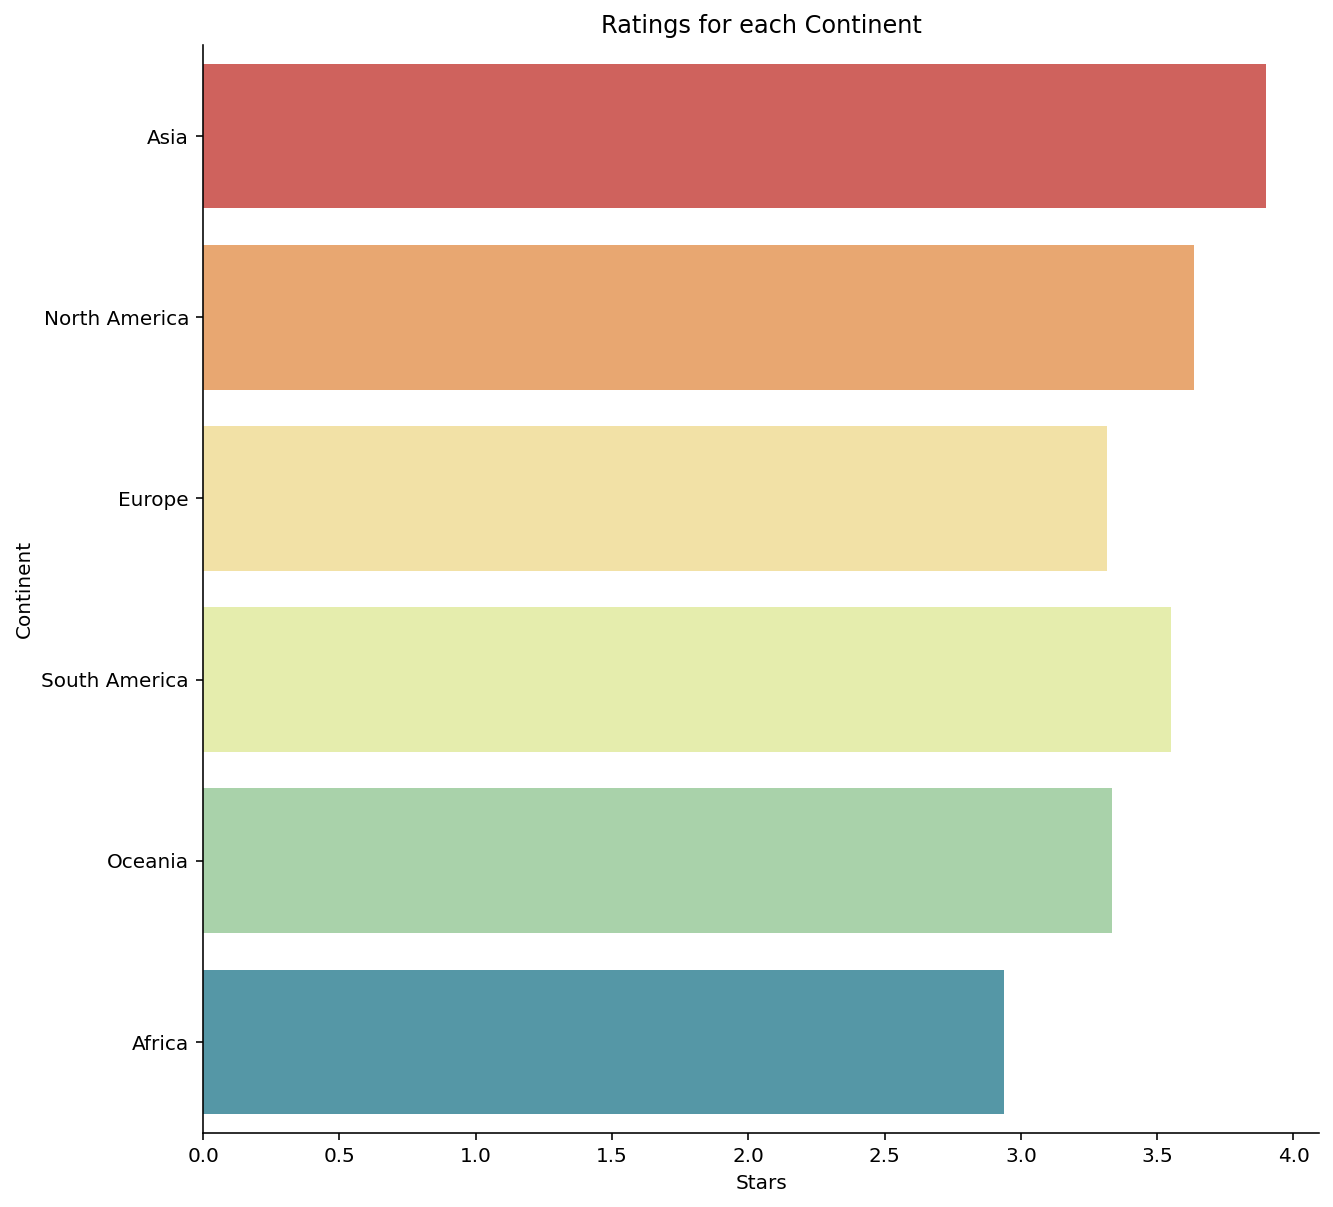

In [13]:
plt.figure(figsize = (10, 10))

barplot_continent_stars = sns.barplot(x = 'Stars', y = 'continent', data = new_df, palette = 'Spectral', ci= None)
#scatterplot.set_xticks(range(17))
#scatterplot.set_xticklabels(values)

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
barplot_continent_stars.set_title('Ratings for each Continent')
barplot_continent_stars.set_xlabel('Stars')
barplot_continent_stars.set_ylabel('Continent');

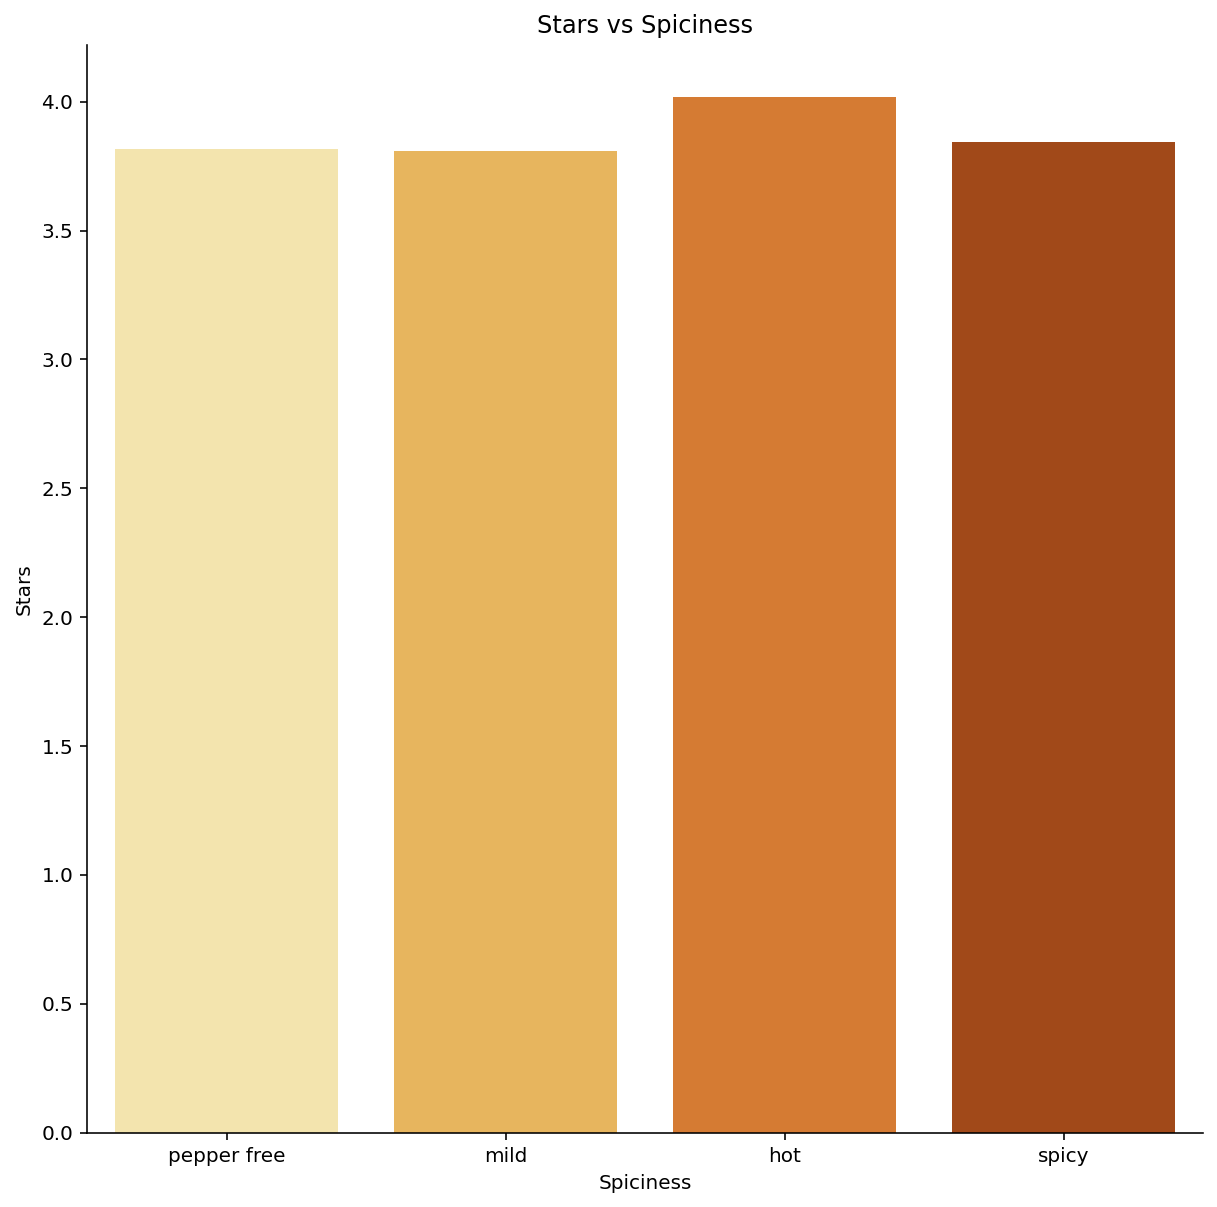

In [14]:
plt.figure(figsize = (10, 10))

barplot_stars_rating = sns.barplot(data = new_df, y = 'Stars', x='Spiciness', palette = 'YlOrBr', ci= None)

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
barplot_stars_rating.set_title('Stars vs Spiciness')
barplot_stars_rating.set_ylabel('Stars')
barplot_stars_rating.set_xlabel('Spiciness');

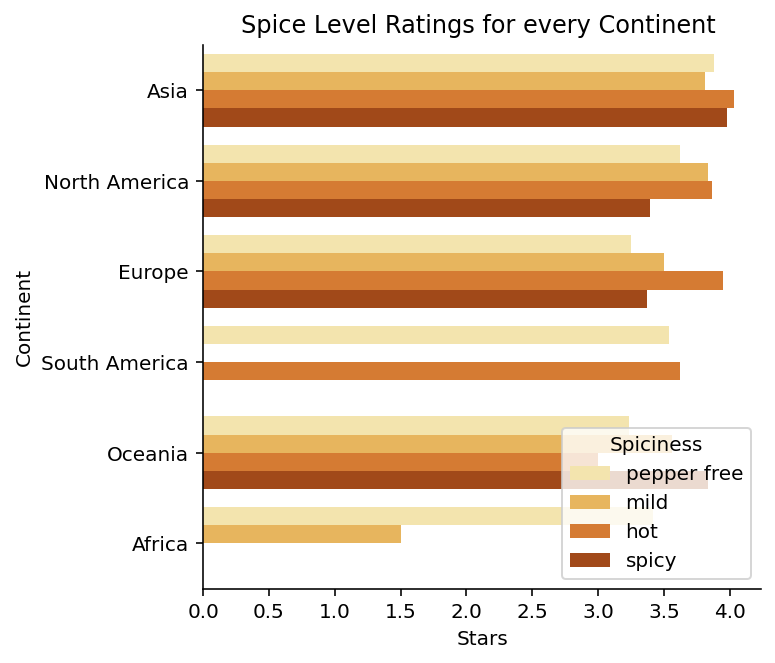

In [15]:
plt.figure(figsize = (5, 5))

barplot_continent_stars_spiciness_2 = sns.barplot(data = new_df, x = 'Stars', y = 'continent', hue = 'Spiciness', palette = 'YlOrBr', ci = None)

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
barplot_continent_stars_spiciness_2.set_title('Spice Level Ratings for every Continent ')
barplot_continent_stars_spiciness_2.set_xlabel('Stars')
barplot_continent_stars_spiciness_2.set_ylabel('Continent');


In [16]:
asian_countries = new_df[new_df['continent'] == 'Asia']
asian_countries

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3.00,pepper free,pepper free,0,Asia
1,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.50,pepper free,pepper free,0,Asia
2,Hi Lai Foods,Lai Noodle Vegan Sesame Paste Flavor,Pack,Taiwan,5.00,pepper free,pepper free,0,Asia
3,Ve Wong,Artificial Peppered Beef Flavor,Pack,Taiwan,3.50,pepper free,mild,"(100, 2500)",Asia
4,iNoodle,Flat Noodle Soy Sauce Flavor,Pack,Taiwan,3.25,pepper free,mild,"(100, 2500)",Asia
...,...,...,...,...,...,...,...,...,...
4007,Mama,Instant Noodles coconut Milk Flavour,Cup,Myanmar,5.00,pepper free,pepper free,0,Asia
4009,Mama,Instant Noodles chicken Green Curry Flavour,Pack,Cambodia,5.00,pepper free,pepper free,0,Asia
4010,Mama,Instant Noodles Stewed Beef Flavour,Pack,Cambodia,3.50,pepper free,pepper free,0,Asia
4011,Mama,Instant Noodles Shrimp Tom Yum Flavour,Pack,Cambodia,4.00,pepper free,hot,"(10000, 50000)",Asia


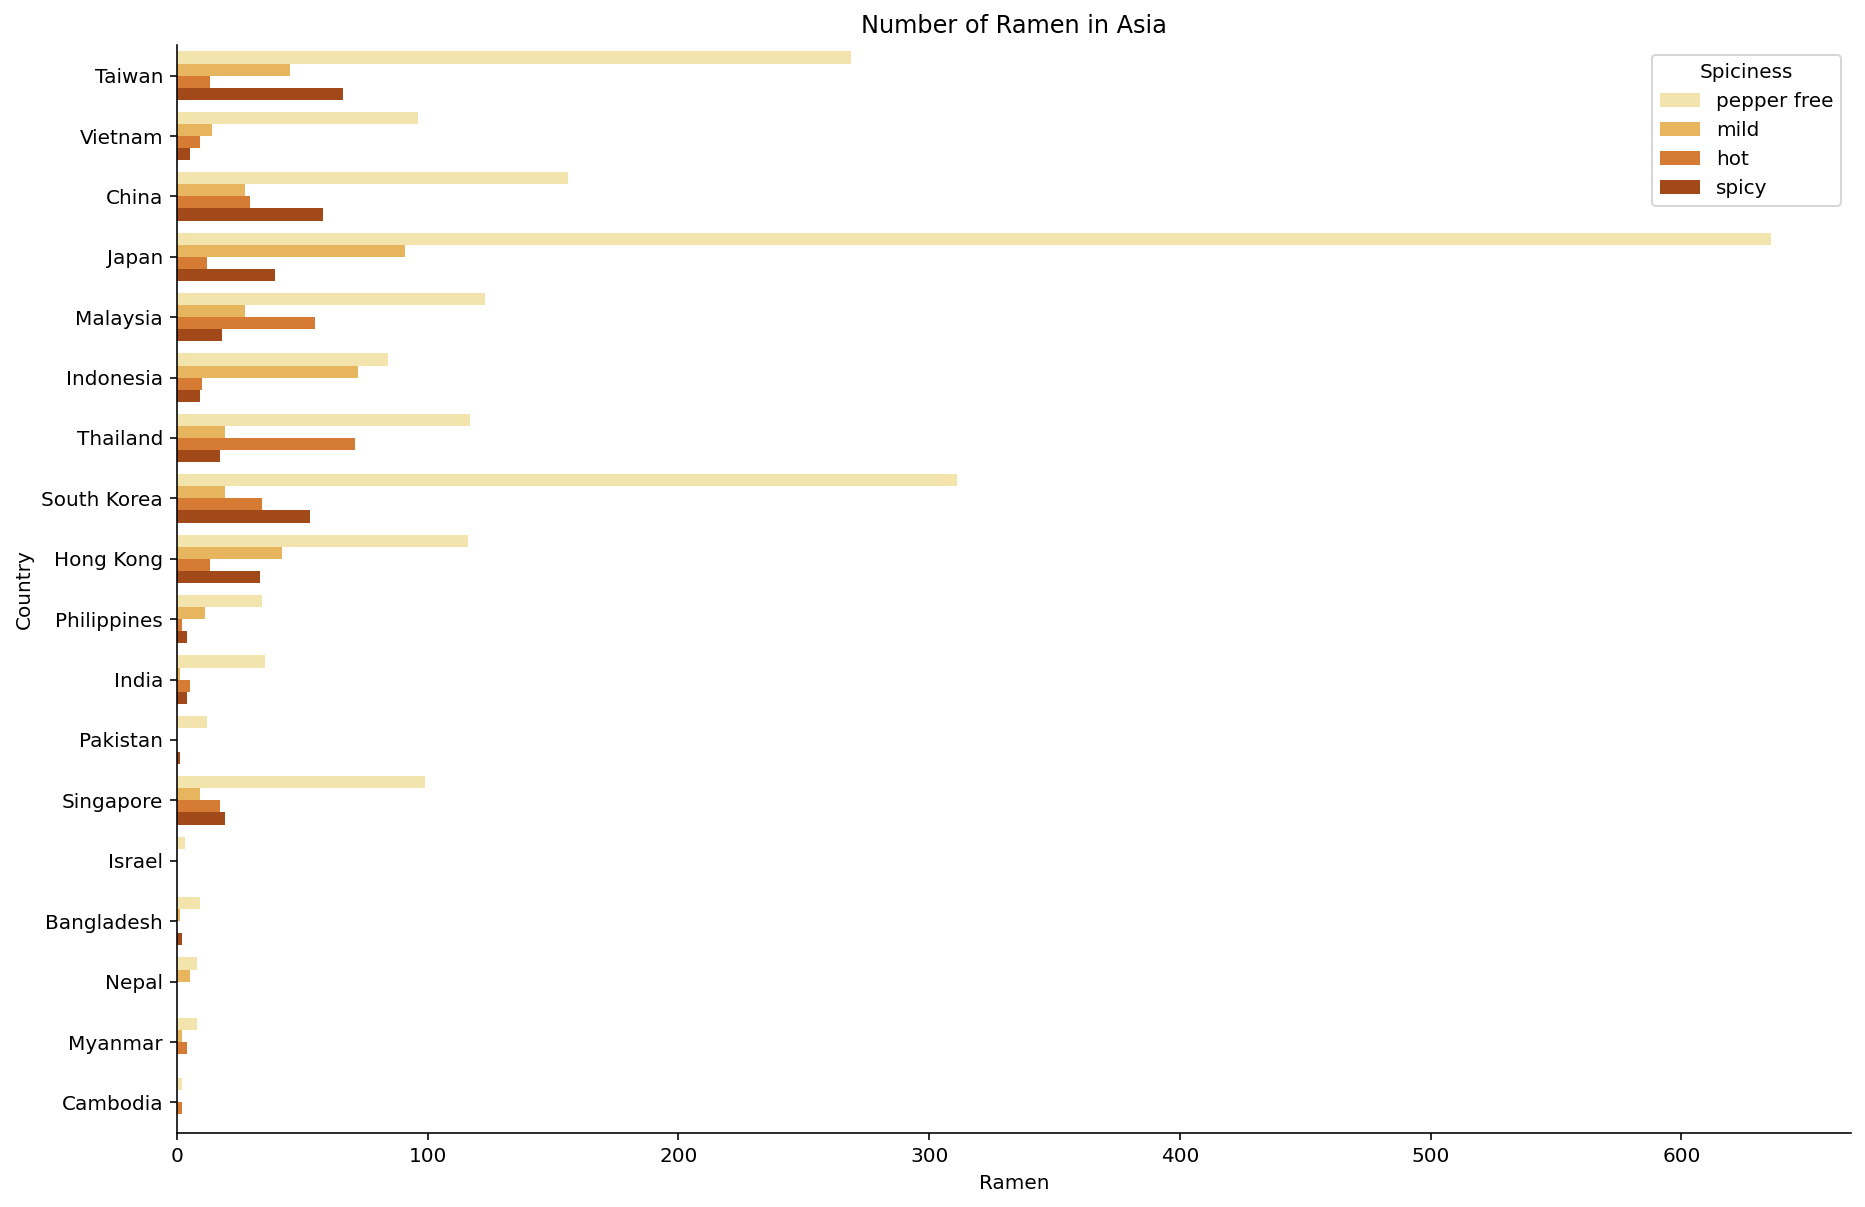

In [17]:
plt.figure(figsize = (15, 10))

asian_countries_count = sns.countplot(y = 'Country', hue='Spiciness', data = asian_countries, palette = 'YlOrBr')

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
asian_countries_count.set_title('Number of Ramen in Asia')
asian_countries_count.set_ylabel('Country')
asian_countries_count.set_xlabel('Ramen');

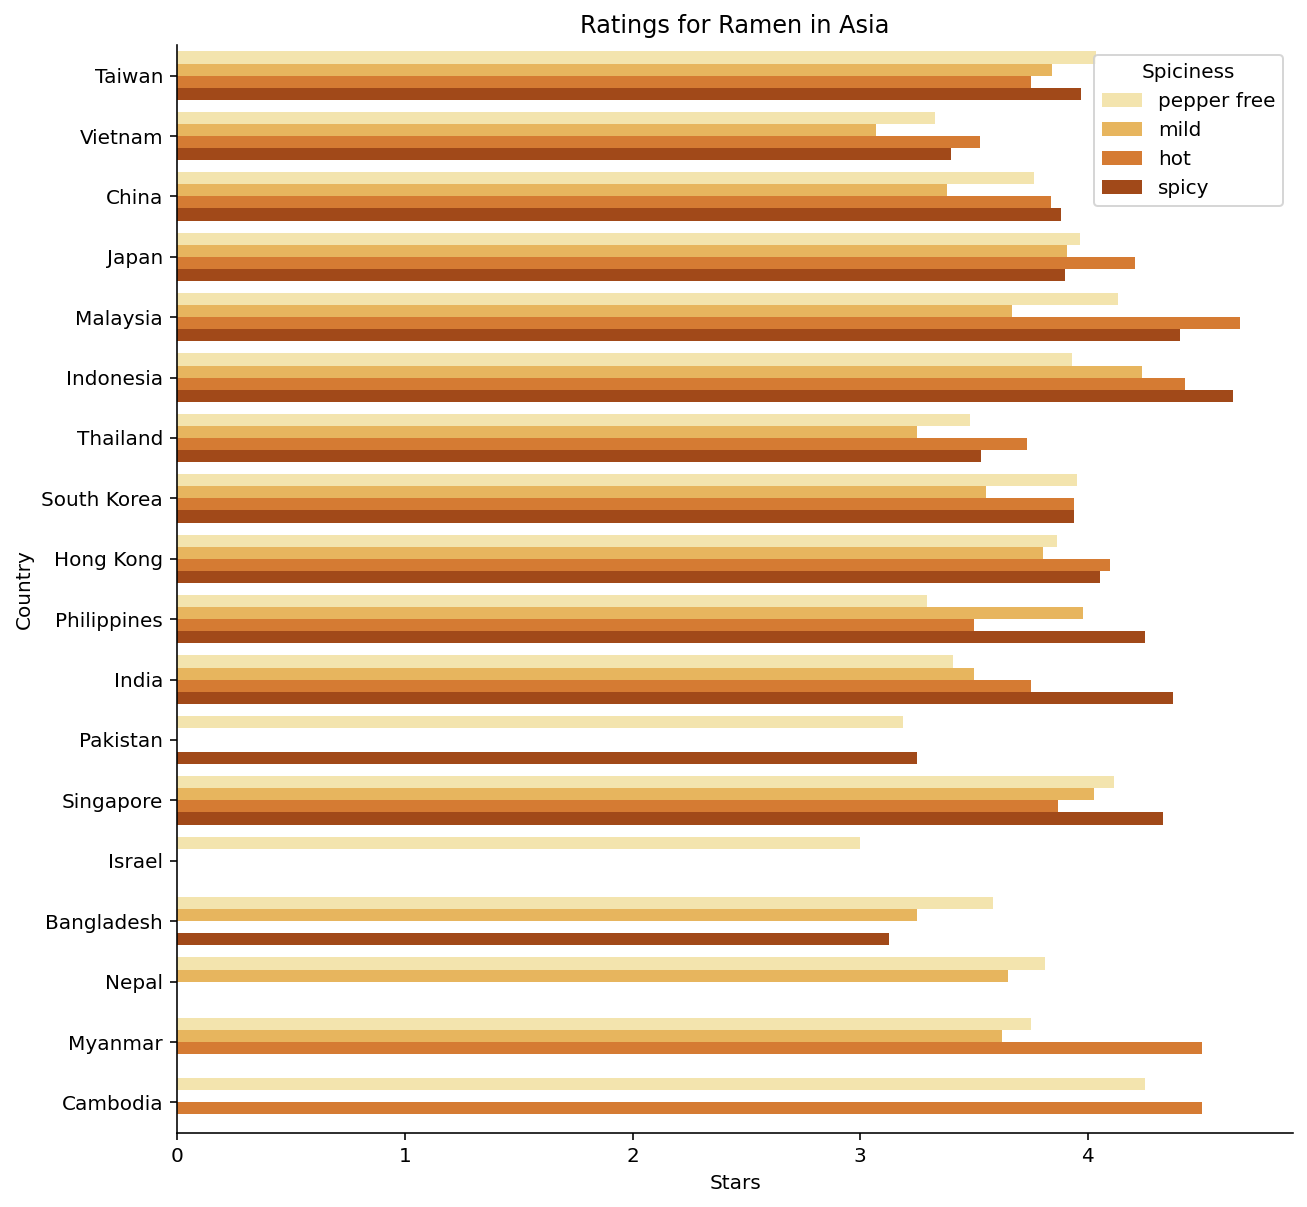

In [18]:
plt.figure(figsize = (10, 10))

barplot_stars_rating_per_country_na = sns.barplot(data = asian_countries, x = 'Stars', y='Country', hue = 'Spiciness', palette = 'YlOrBr', ci = None)

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
barplot_stars_rating_per_country_na.set_title('Ratings for Ramen in Asia')
barplot_stars_rating_per_country_na.set_ylabel('Country')
barplot_stars_rating_per_country_na.set_xlabel('Stars');

In [19]:
new_df['continent'].value_counts()

Asia             3107
North America     618
Europe            106
South America      34
Oceania            30
Africa              4
Name: continent, dtype: int64

In [20]:
na_countries = new_df[new_df['continent'] == 'North America']
na_countries

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
405,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.50,pepper free,mild,"(100, 2500)",North America
406,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,pepper free,hot,"(10000, 50000)",North America
407,immi,Spicy Beef Flavor Ramen Soup,Pack,United States,3.75,spicy,spicy,"(2500, 10000)",North America
408,Nongshim,Tonkotsu Ramen With Kuromayu Black Garlic Oil,Bowl,United States,4.00,pepper free,mild,"(100, 2500)",North America
409,Vite Ramen,Vegan White Miso v1.3 Prototype,Pack,United States,3.75,pepper free,pepper free,0,North America
...,...,...,...,...,...,...,...,...,...
3883,Mr. Noodles,Vegetable,Pack,Canada,1.75,pepper free,pepper free,0,North America
3884,Mr. Noodles,Chicken,Pack,Canada,3.00,pepper free,pepper free,0,North America
3885,Mr. Noodles,Spicy Beef,Pack,Canada,1.75,spicy,spicy,"(2500, 10000)",North America
3886,Mr. Noodles,Beef,Pack,Canada,3.00,pepper free,pepper free,0,North America


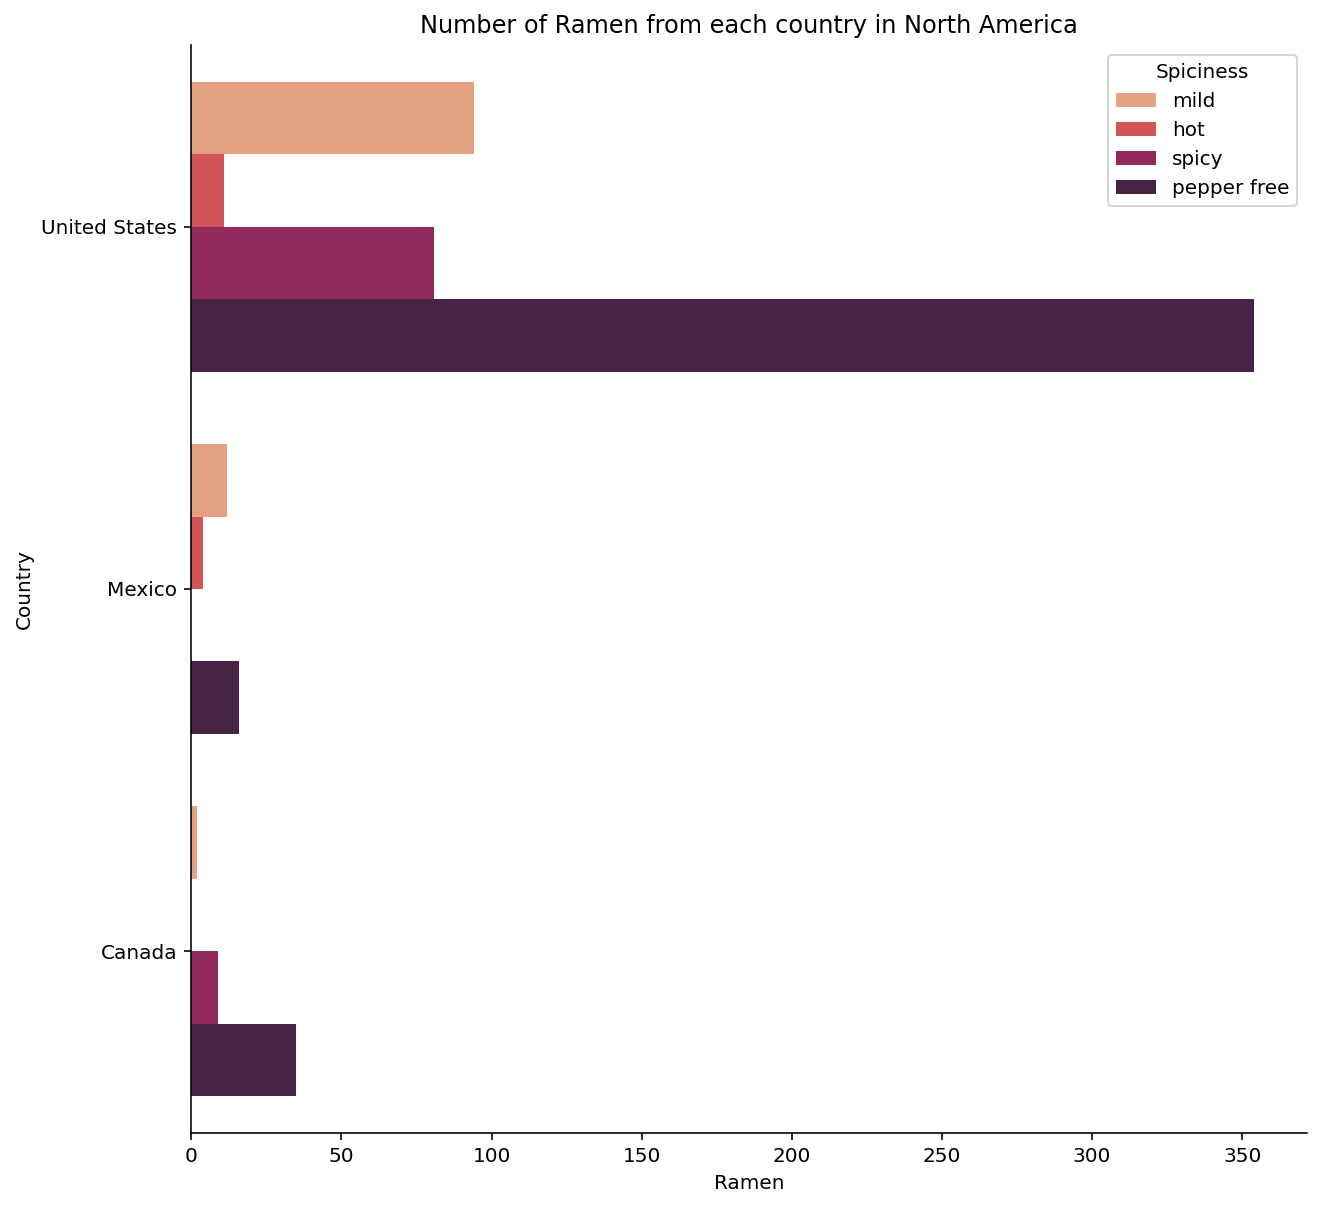

In [21]:
plt.figure(figsize = (10, 10))

na_countries_count = sns.countplot(y = 'Country', hue='Spiciness', data = na_countries, palette = 'rocket_r')

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
na_countries_count.set_title('Number of Ramen from each country in North America')
na_countries_count.set_ylabel('Country')
na_countries_count.set_xlabel('Ramen');

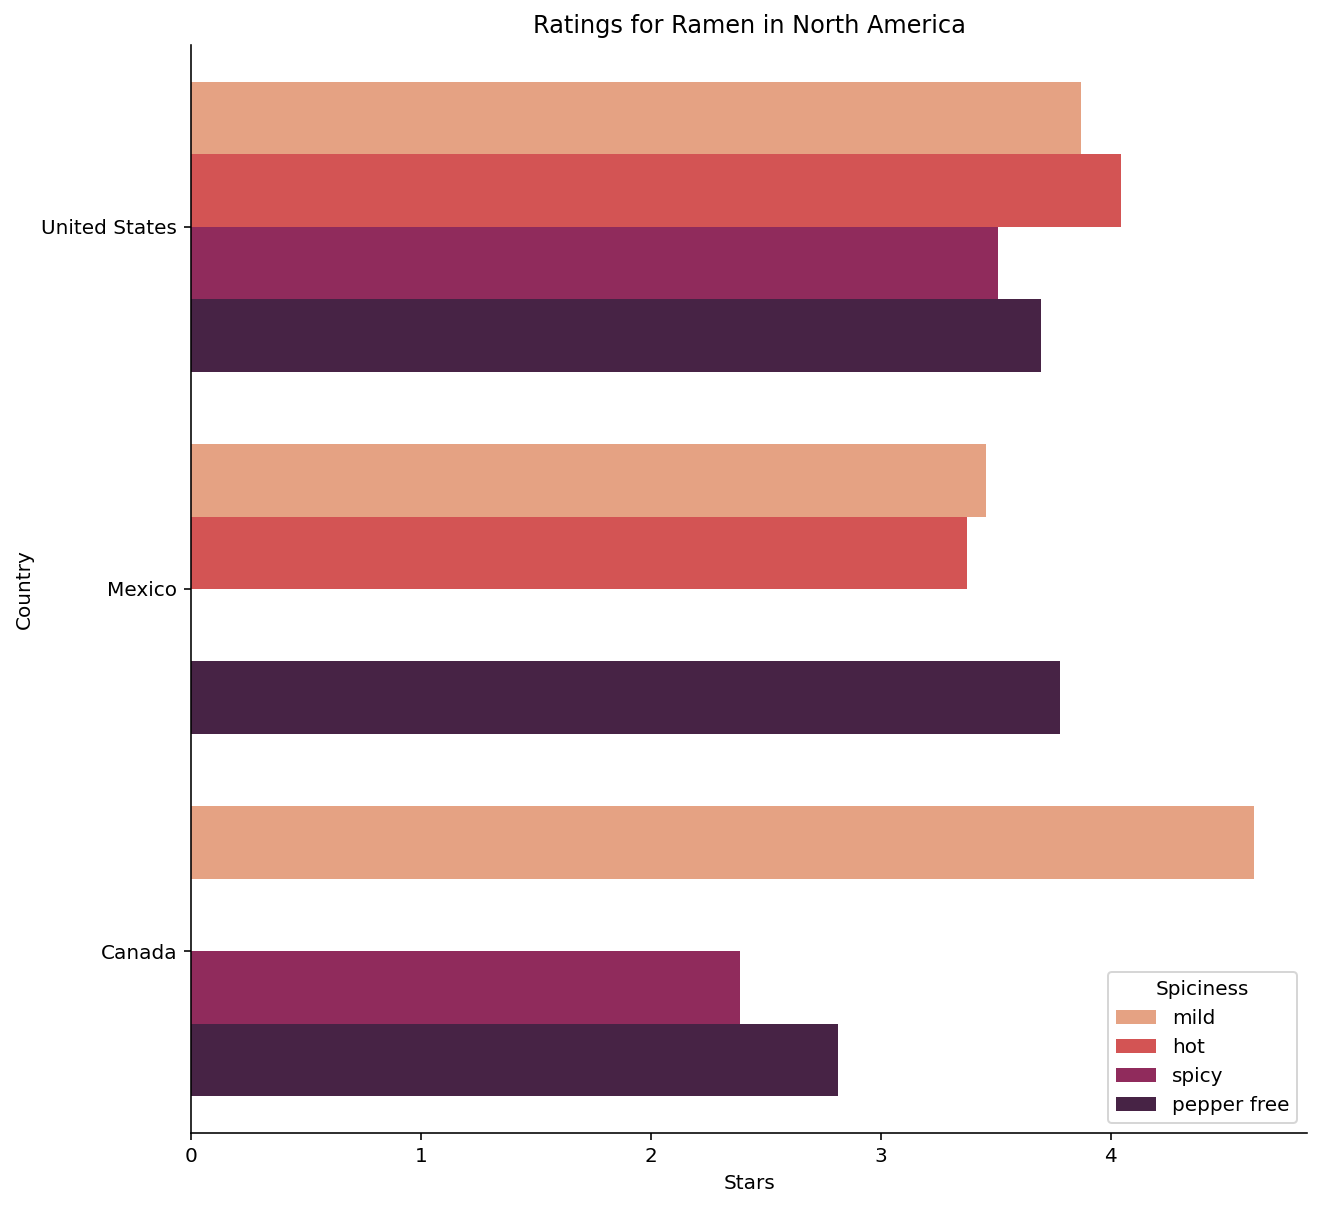

In [22]:
plt.figure(figsize = (10, 10))

barplot_stars_rating_per_country_na = sns.barplot(data = na_countries, x = 'Stars', y='Country', hue = 'Spiciness', palette = 'rocket_r', ci = None)

# remove the top and right lines
sns.despine()

# add title and axis labels (modify x-axis label)
barplot_stars_rating_per_country_na.set_title('Ratings for Ramen in North America')
barplot_stars_rating_per_country_na.set_ylabel('Country')
barplot_stars_rating_per_country_na.set_xlabel('Stars');

# Create a map for average star rating

In [23]:
file = 'ramen.csv'
df = pd.read_csv(file)
# df.astype({'Stars': 'float'})
def star_converted(s):
    rating = s.split('/')[0]
    try:
        return float(rating)
    except ValueError:
        return None
df.Stars= df.Stars.apply(star_converted)

In [24]:
star_df = df.groupby('Country').mean().reset_index()

In [25]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
country_shapes = f'{url}/world-countries.json'
geoJSON_df = gpd.read_file(country_shapes)
geoJSON_df = geoJSON_df.rename(columns = {"id":"country_code",'name':'Country'})
final_df = geoJSON_df.merge(star_df, on = "Country")
def get_lat_long(pt):
    '''
    Get centroid point of a state
    '''
    return (pt.y, pt.x)
final_df['coor'] = final_df['geometry'].centroid.apply(get_lat_long)
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='Ramen World',
    data=final_df,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['Country', 'Stars'],
    key_on='feature.properties.name',
    fill_color='PuRd',
    # nan_fill_color='white'
).add_to(m)

# nans = df[df["Stars"].isnull()]['POSTAL.CODE'].values
# gdf_nans = df[df['POSTAL.CODE'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# # Add hover functionality.
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = final_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Country','Stars',],
        aliases=['Country','Star rating',],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
m

<ipython-input-25-679aeff949c1>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  final_df['coor'] = final_df['geometry'].centroid.apply(get_lat_long)


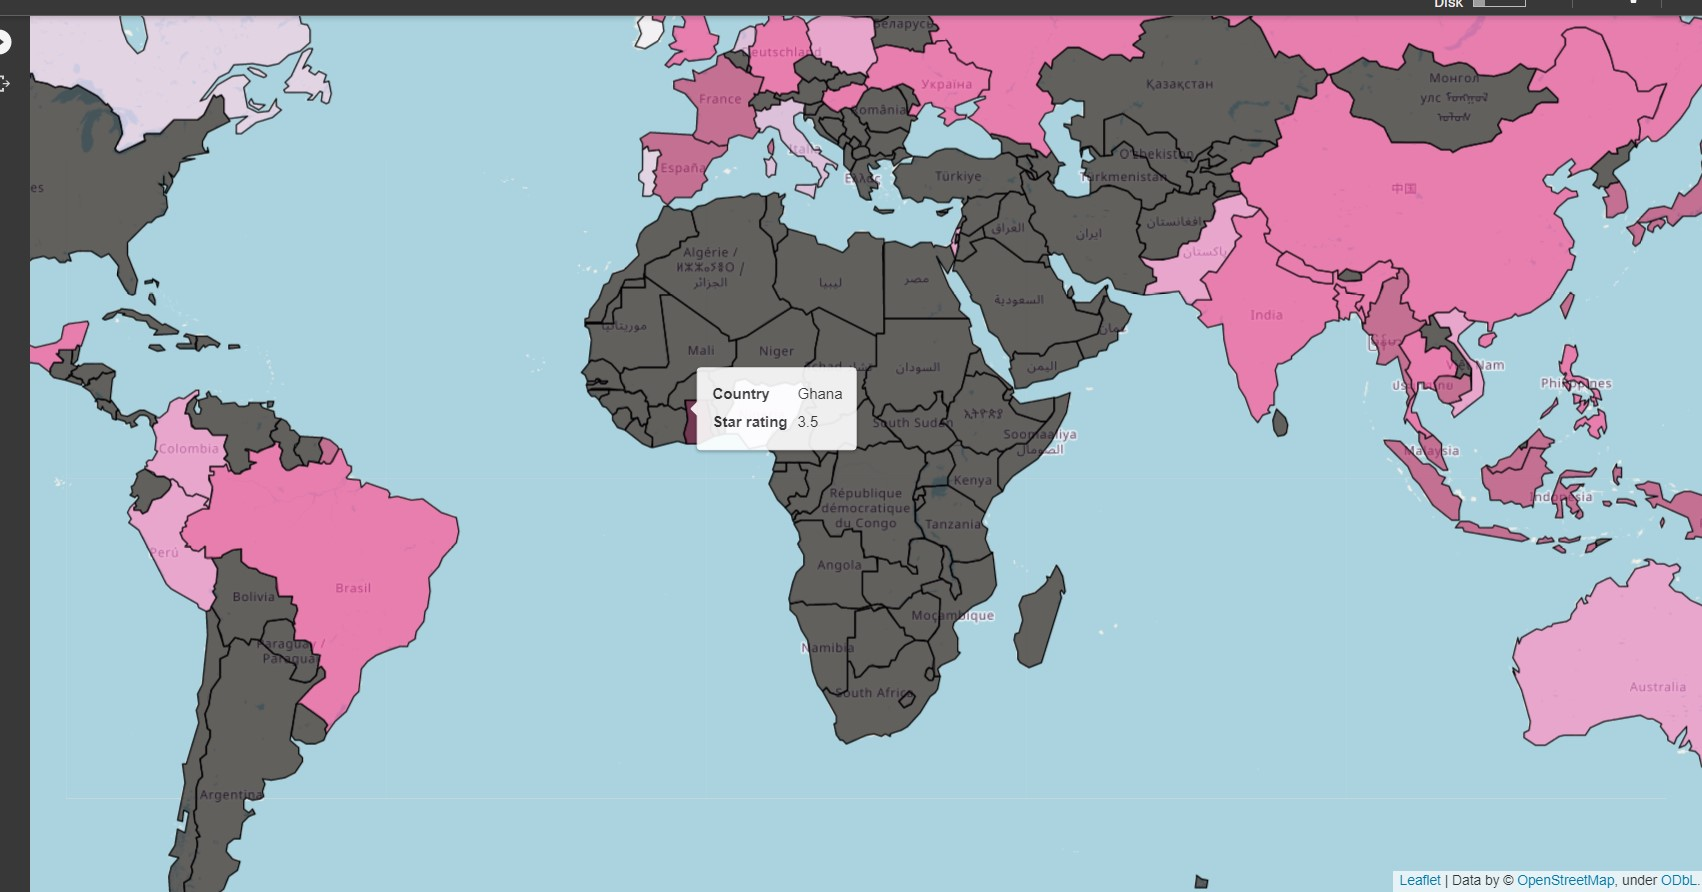

In [26]:
from IPython.display import Image
Image(filename='pictures/ghana.jpg') 

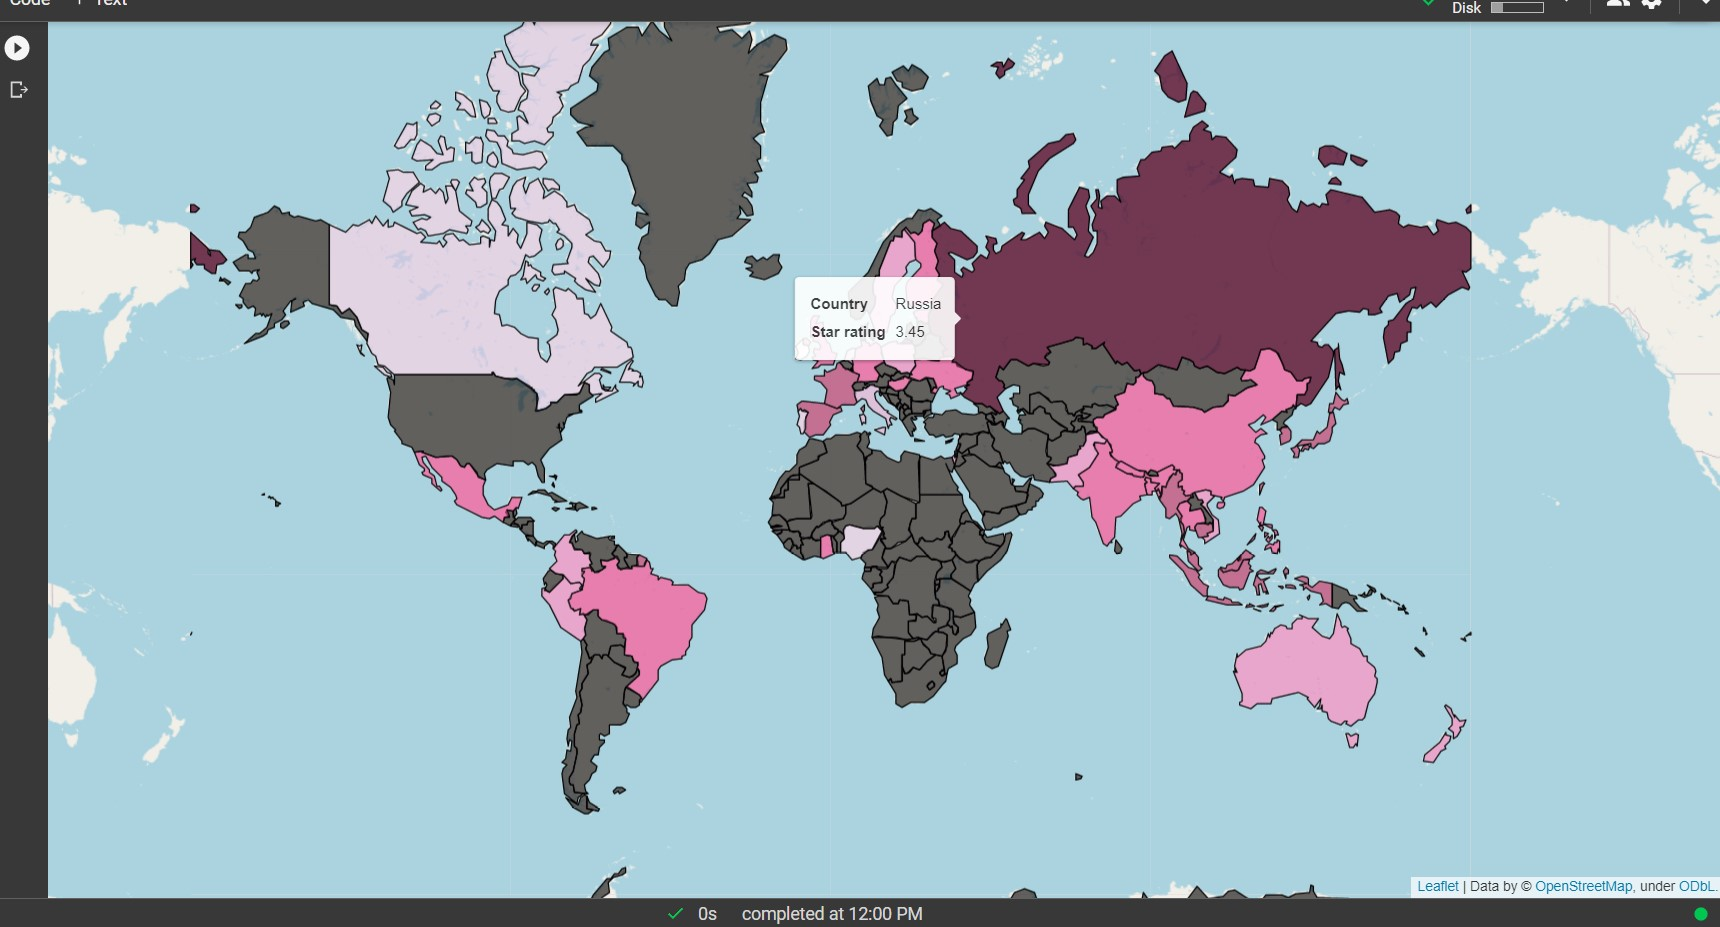

In [27]:
Image(filename='pictures/russia.jpg') 